In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import importlib
from IPython import display

import time

In [2]:
sys.path.append('../..')
import ReconNet
import helper
# importlib.reload(ReconNet)

In [22]:
net = ReconNet.ReconNet()
net.FromFile('../../train/data/param.txt')
net.cSetDevice(0)

img = np.load('../../train/data/real_2D_3_layer_mean/L291_full_hann.npy')[[48], ...]


t1 = time.time()
# for i in range(10):
siddon = net.cSiddonFanProjection3d(img)

prj = siddon
# prj = np.zeros_like(siddon)
# prj[:, :, 450, :] = 1

siddonBP = net.cSiddonFanBackprojection3d(prj)
t2 = time.time()

# for i in range(10):
dd = net.cDDFanProjection3d(img)
ddBP = net.cDDFanBackprojection3d(prj, type_projector=0)
t3 = time.time()

print (t2 - t1, t3 - t2)


0.08344912528991699 0.1414809226989746


In [23]:
fsino = net.cFilter3d(siddon, 2)
siddonImg = net.cPixelBackprojection3d(fsino)
ddImg = net.cDDFanBackprojection3d(fsino, type_projector=1)

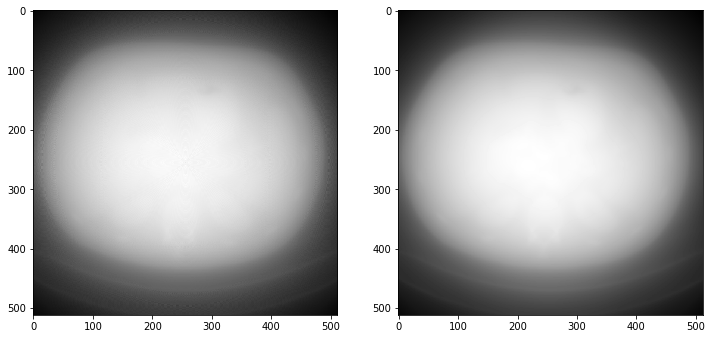

In [24]:
plt.figure(figsize=[12,6])
plt.subplot(121); plt.imshow(siddonBP[0,...,0].T, 'gray')
plt.subplot(122); plt.imshow(ddBP[0,...,0].T, 'gray')

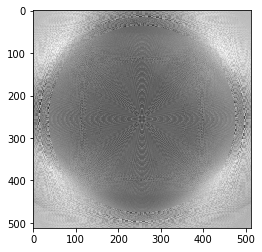

In [26]:
plt.imshow((siddonBP - ddBP)[0,...,0].T, 'gray')

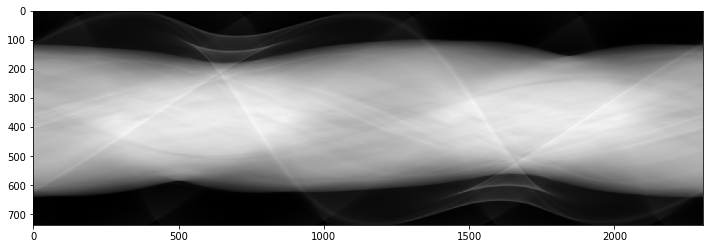

In [5]:
plt.figure(figsize=[12,6])
plt.imshow(dd[0,...,0], 'gray', vmin=0, vmax=8)

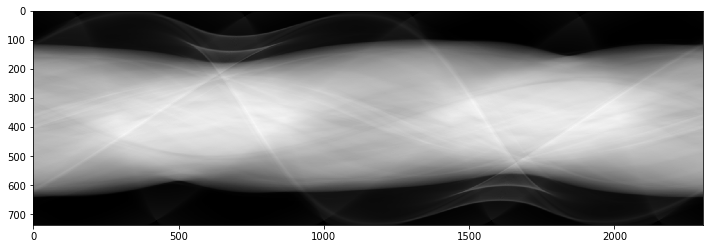

In [7]:
plt.figure(figsize=[12,6])
plt.imshow(siddon[0,...,0], 'gray', vmin=0, vmax=8)

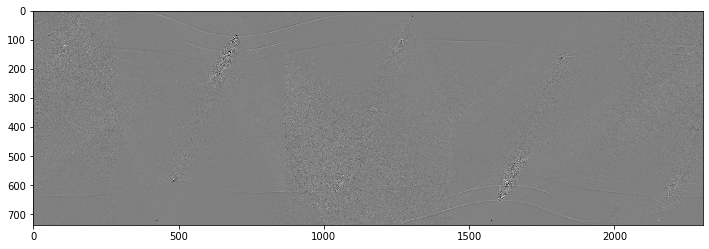

In [9]:
plt.figure(figsize=[12,6])
plt.imshow((siddon - dd)[0,...,0], 'gray', vmin=-0.1, vmax=0.1)

In [17]:
sampleRate = 4

tf.reset_default_graph()
net = ReconNet.ReconNet()
net.FromFile('../../train/data/param.txt')
net.rotview = int(net.rotview / sampleRate)
net.UpdateAngularSampling()

inputImg = tf.placeholder(tf.float32, [1, net.nx, net.ny, 1], 'inputImg')
inputPrj = tf.placeholder(tf.float32, [1, net.nu, net.rotview, 1], 'inputPrj')
inputAngles = tf.placeholder(tf.float32, [net.rotview], 'inputAngles')
voxelSz = tf.placeholder(tf.float32, [3], 'voxelSz')
angles = np.array(net.angles)

fpTensor = net.projection3d(inputImg, inputAngles, voxelSz)
bpTensor = net.backprojection3d(inputPrj, inputAngles, voxelSz)

lossTensor = tf.reduce_sum(fpTensor ** 2) / 2
gradTensor = tf.gradients(lossTensor, inputImg)[0]

In [22]:
img = helper.ReadImg('../../train/data/noiseless/img/L067.raw', net.nx, net.ny)
img = img[np.newaxis, ...]
prj = np.load('../../train/data/lowdose/1.5e5/sino-4/L067.npy')
res = helper.LoadResolutionFile('../../train/data/resolution.npz')['L067']

In [19]:
imgSlice = img[...,[0]]
prjSlice = prj[...,[0]]

In [20]:
sess = tf.Session(config = tf.ConfigProto(gpu_options = tf.GPUOptions(visible_device_list='0', allow_growth=True)))
sess.run(tf.global_variables_initializer())

In [40]:
net.dx = res
net.dy = res
cfp = net.cSiddonFanProjection3d(imgSlice)

In [41]:
fp = sess.run(fpTensor, {inputImg: imgSlice, inputAngles: net.angles, voxelSz: [res, res, 1]})

In [34]:
bp = sess.run(bpTensor, {inputPrj: prjSlice, inputAngles: net.angles, voxelSz: [res, res, 1]})

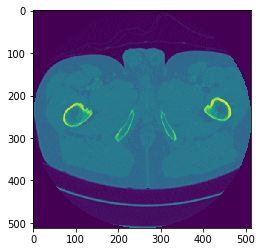

In [36]:
plt.imshow(img[0, ...,0 ])